In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import dataAgglomeration as da
import numpy as np
from numpy import linalg
import math

In [3]:
### Results from interFlow
agglomerator = da.data_agglomerator("risingBubbleAcc3D.parameter","bubblepproc.dat", 
                                     "./isoAdv-risingBubbleAcc3D_00000_templateCase")
agglomerator.show_failed_variations()
agglomerator.write_agglomerated_study_data("isoAdv-risingBubbleAcc3D.csv")
dframe_isoAdv_risingU = agglomerator.study_dataframe()
dframe_isoAdv_risingU = dframe_isoAdv_risingU.sort_index()


Variants without valid data:
----------------------------
#Variation | Reason
----------------------------


ValueError: The number of existing variations equals 0, is the parameter study empty?

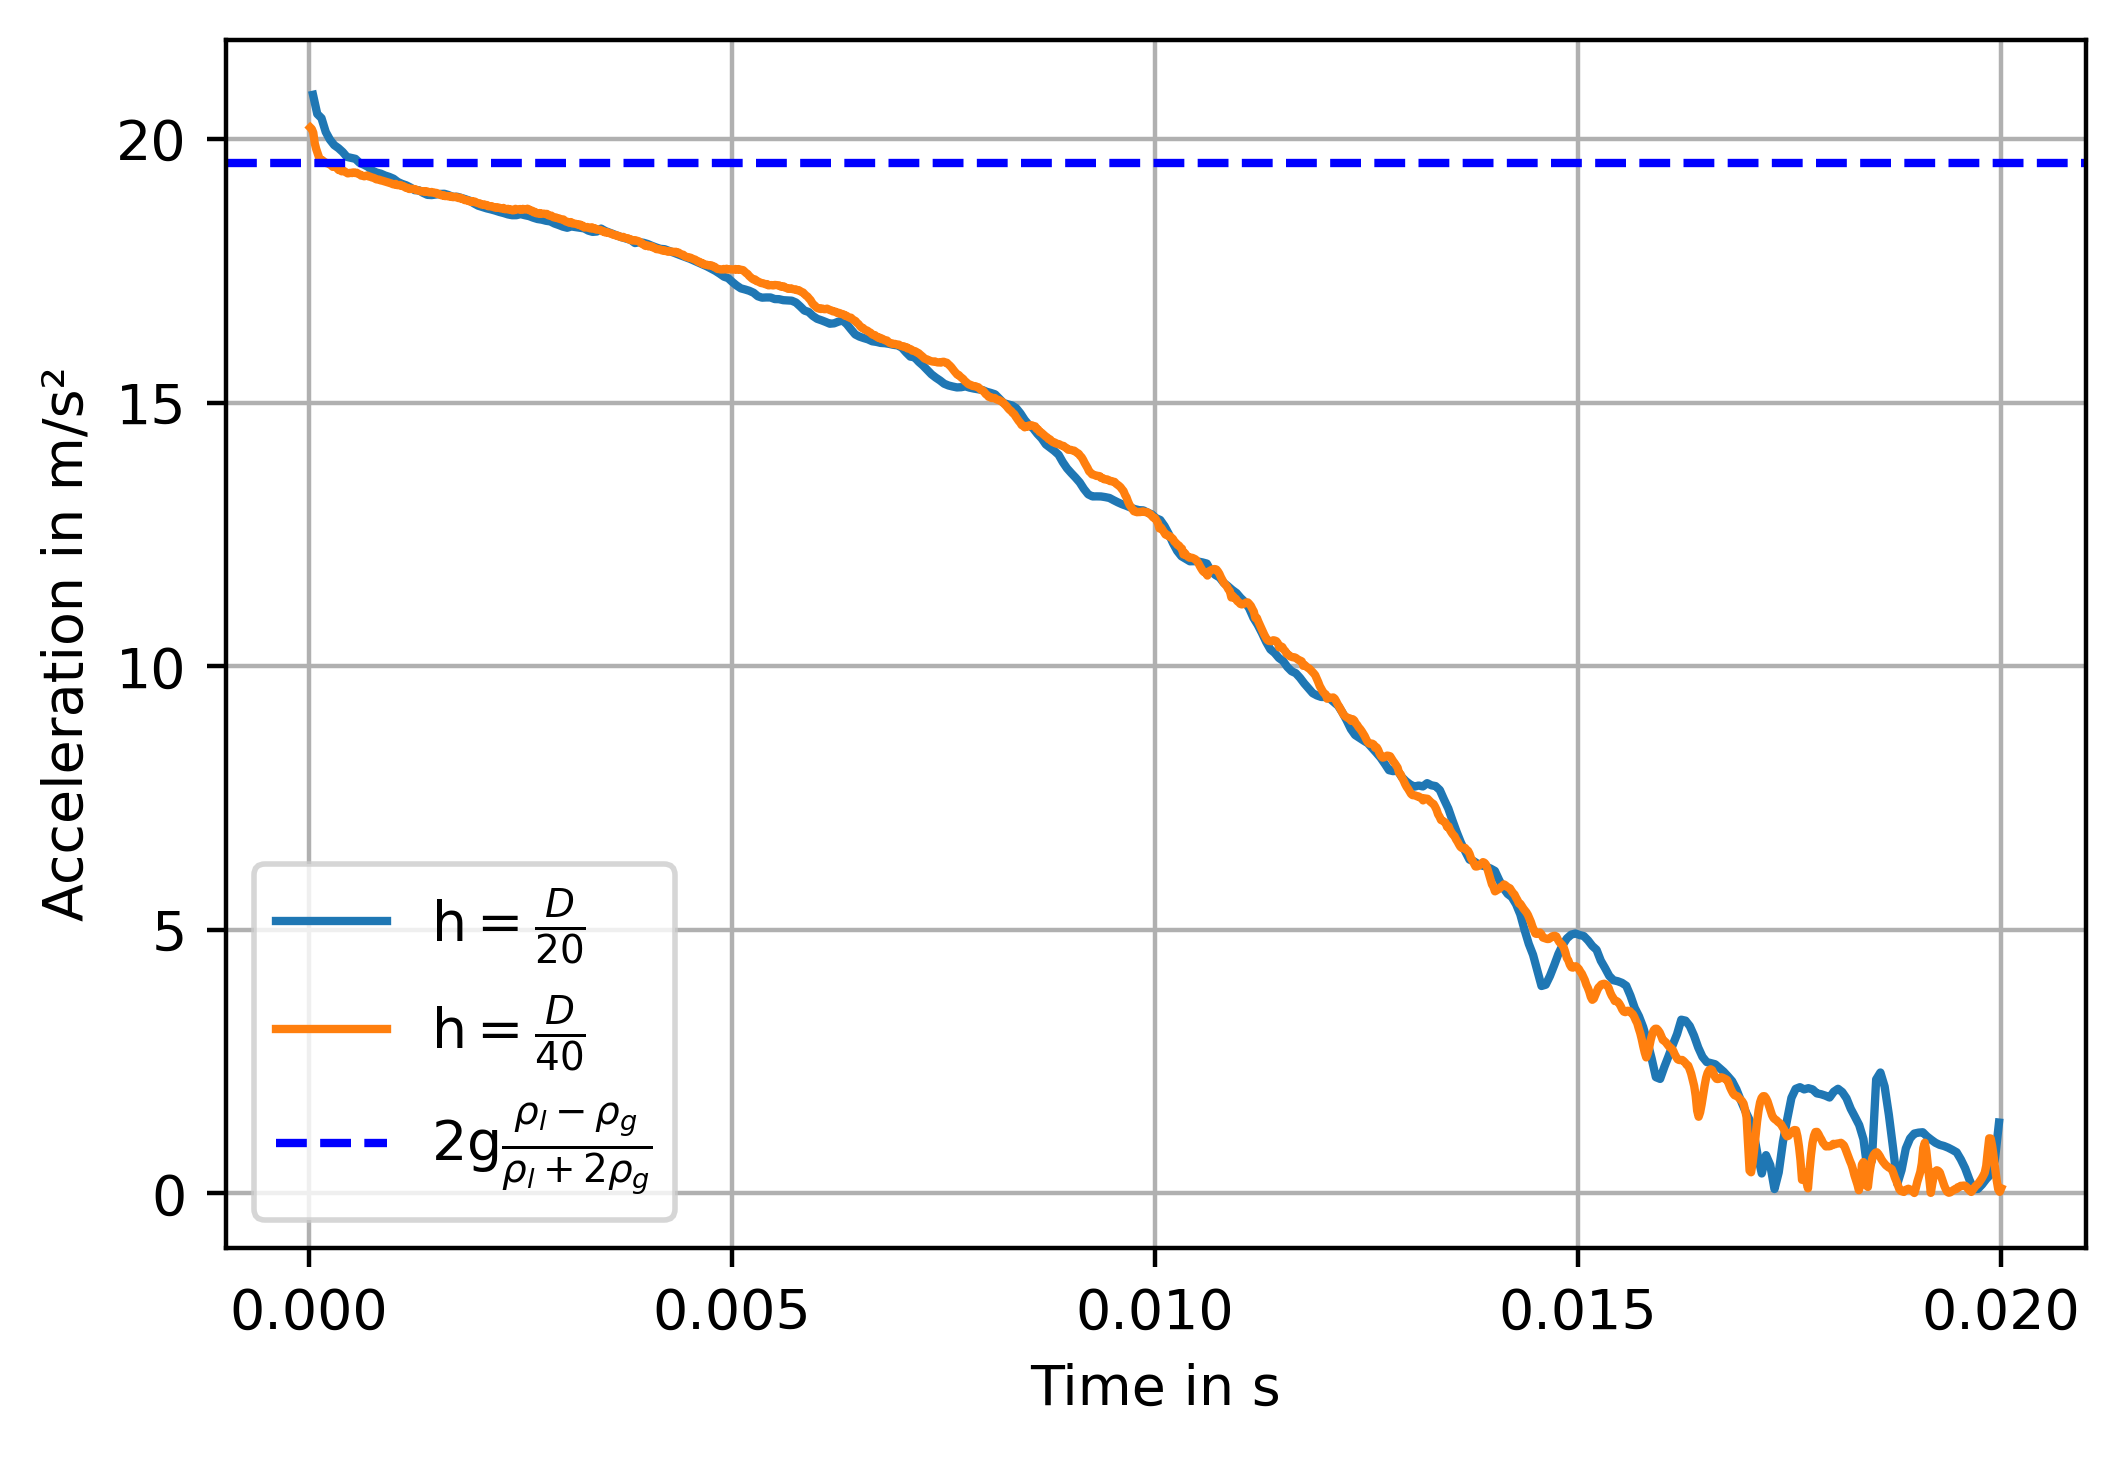

In [6]:
df20 = dframe_isoAdv_risingU.loc[dframe_isoAdv_risingU.index.get_level_values('resolution') == 240]
df40 = dframe_isoAdv_risingU.loc[dframe_isoAdv_risingU.index.get_level_values('resolution') == 480]

accN20 = linalg.norm(df20[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/df20["time"].diff()
accN40 = linalg.norm(df40[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/df40["time"].diff()

rcParams["figure.dpi"] = 400
g = 9.80665
rhol= 998.21
rhog = 1.2047

acc = 2*g*(rhol - rhog)/(rhol+2*rhog)
t=np.linspace(0,0.02)
vel=acc*t


plt.plot(df20["time"], accN20, label=r"h$=\frac{D}{20}$")
plt.plot(df40["time"], accN40, label=r"h$=\frac{D}{40}$")
plt.axhline(y=acc, linestyle='--', color='blue', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$")
#plt.xlim(0,0.001)
#plt.ylim(18)
plt.xticks([0,0.005,0.01,0.015,0.02])
#plt.plot(t, vel, label="Analytical")
plt.xlabel("Time in s")
plt.ylabel("Acceleration in m/s²")
plt.grid()
plt.legend()
plt.savefig('accPlot_zoomedIn.png', facecolor='w')
plt.show()

In [50]:
def estimate_acceleration(times, velocities):
    """
    Estimate acceleration using least squares fit on every three points.
    
    Parameters:
    times (array-like): Array of time points.
    velocities (array-like): Array of velocities corresponding to the time points.
    
    Returns:
    np.ndarray: Array of estimated accelerations.
    """
    n = len(times)
    accelerations = []

    for i in range(n - 2):
        # Select the triplet of points
        t_triplet = np.array([times[i], times[i+1], times[i+2]])
        v_triplet = np.array([velocities[i], velocities[i+1], velocities[i+2]])
        
        # Construct the matrix for the least squares fit
        A = np.vstack([t_triplet**2, t_triplet, np.ones(3)]).T
        
        # Solve the least squares problem to find the coefficients
        coeffs = np.linalg.lstsq(A, v_triplet, rcond=None)[0]
        
        # The acceleration is 2 times the coefficient of the t^2 term
        acceleration = 2 * coeffs[0]
        accelerations.append(acceleration)
    
    return np.array(accelerations)

In [52]:
accLS3P = estimate_acceleration(df20["time"].values, df20["z-Velocity"].values)

In [60]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

def estimate_acceleration(df, time_col, velocity_col, window_size=5, polyorder=2):
    """
    Estimate acceleration using least squares fit on a larger window with smoothing.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing time and velocity data.
    time_col (str): Name of the column containing time data.
    velocity_col (str): Name of the column containing velocity data.
    window_size (int): Size of the window for smoothing and fitting.
    polyorder (int): Order of the polynomial for Savitzky-Golay filter.
    
    Returns:
    np.ndarray: Array of estimated accelerations.
    """
    times = df[time_col].values
    velocities = df[velocity_col].values

    # Apply Savitzky-Golay filter to smooth the velocity data
    smoothed_velocities = savgol_filter(velocities, window_length=window_size, polyorder=polyorder)
    
    n = len(times)
    half_window = window_size // 2
    accelerations = []

    for i in range(half_window, n - half_window):
        # Select the window of points
        t_window = times[i - half_window:i + half_window + 1]
        v_window = smoothed_velocities[i - half_window:i + half_window + 1]
        
        # Construct the matrix for the least squares fit
        A = np.vstack([t_window**2, t_window, np.ones(window_size)]).T
        
        # Solve the least squares problem to find the coefficients
        coeffs = np.linalg.lstsq(A, v_window, rcond=None)[0]
        
        # The acceleration is 2 times the coefficient of the t^2 term
        acceleration = 2 * coeffs[0]
        accelerations.append(acceleration)
    
    # Pad the beginning and end with NaNs or zeros if necessary
    accelerations = [np.nan]*half_window + accelerations + [np.nan]*half_window
    
    return np.array(accelerations)

# Estimate the accelerations
accelerations = estimate_acceleration(df20, 'time', 'z-Velocity', window_size=5, polyorder=2)

# Print the results
print("Estimated Accelerations:", accelerations)


Estimated Accelerations: [            nan             nan -4.13735770e+03 -3.78534695e+03
 -3.04157325e+03 -2.22066559e+03 -1.53680562e+03 -1.44389170e+03
 -1.23339335e+03 -8.64440948e+02 -7.40613542e+02 -8.89211104e+02
 -9.82735703e+02 -1.00905060e+03 -9.93552777e+02 -8.35479396e+02
 -6.23341306e+02 -5.48530665e+02 -6.40107665e+02 -7.94229725e+02
 -8.90913105e+02 -8.10696698e+02 -7.49896202e+02 -7.35941750e+02
 -7.00360333e+02 -6.26013044e+02 -6.58514584e+02 -5.41058225e+02
 -2.24234379e+02  1.17016034e+02  1.61184674e+02 -6.93951813e+01
 -3.47835318e+02 -4.07257781e+02 -3.19697219e+02 -3.34573429e+02
 -4.88157801e+02 -6.97795105e+02 -8.28248207e+02 -7.85157497e+02
 -6.27559408e+02 -4.78865289e+02 -4.37386139e+02 -4.43306502e+02
 -4.75778360e+02 -4.71427925e+02 -4.25450123e+02 -2.35281490e+02
 -1.03360862e+01  4.64101809e+01 -1.66876337e+02 -3.98205556e+02
 -5.12725452e+02 -4.55122502e+02 -3.60546425e+02 -3.37778615e+02
 -4.43383578e+02 -5.82055209e+02 -6.44864514e+02 -5.16095131e+02


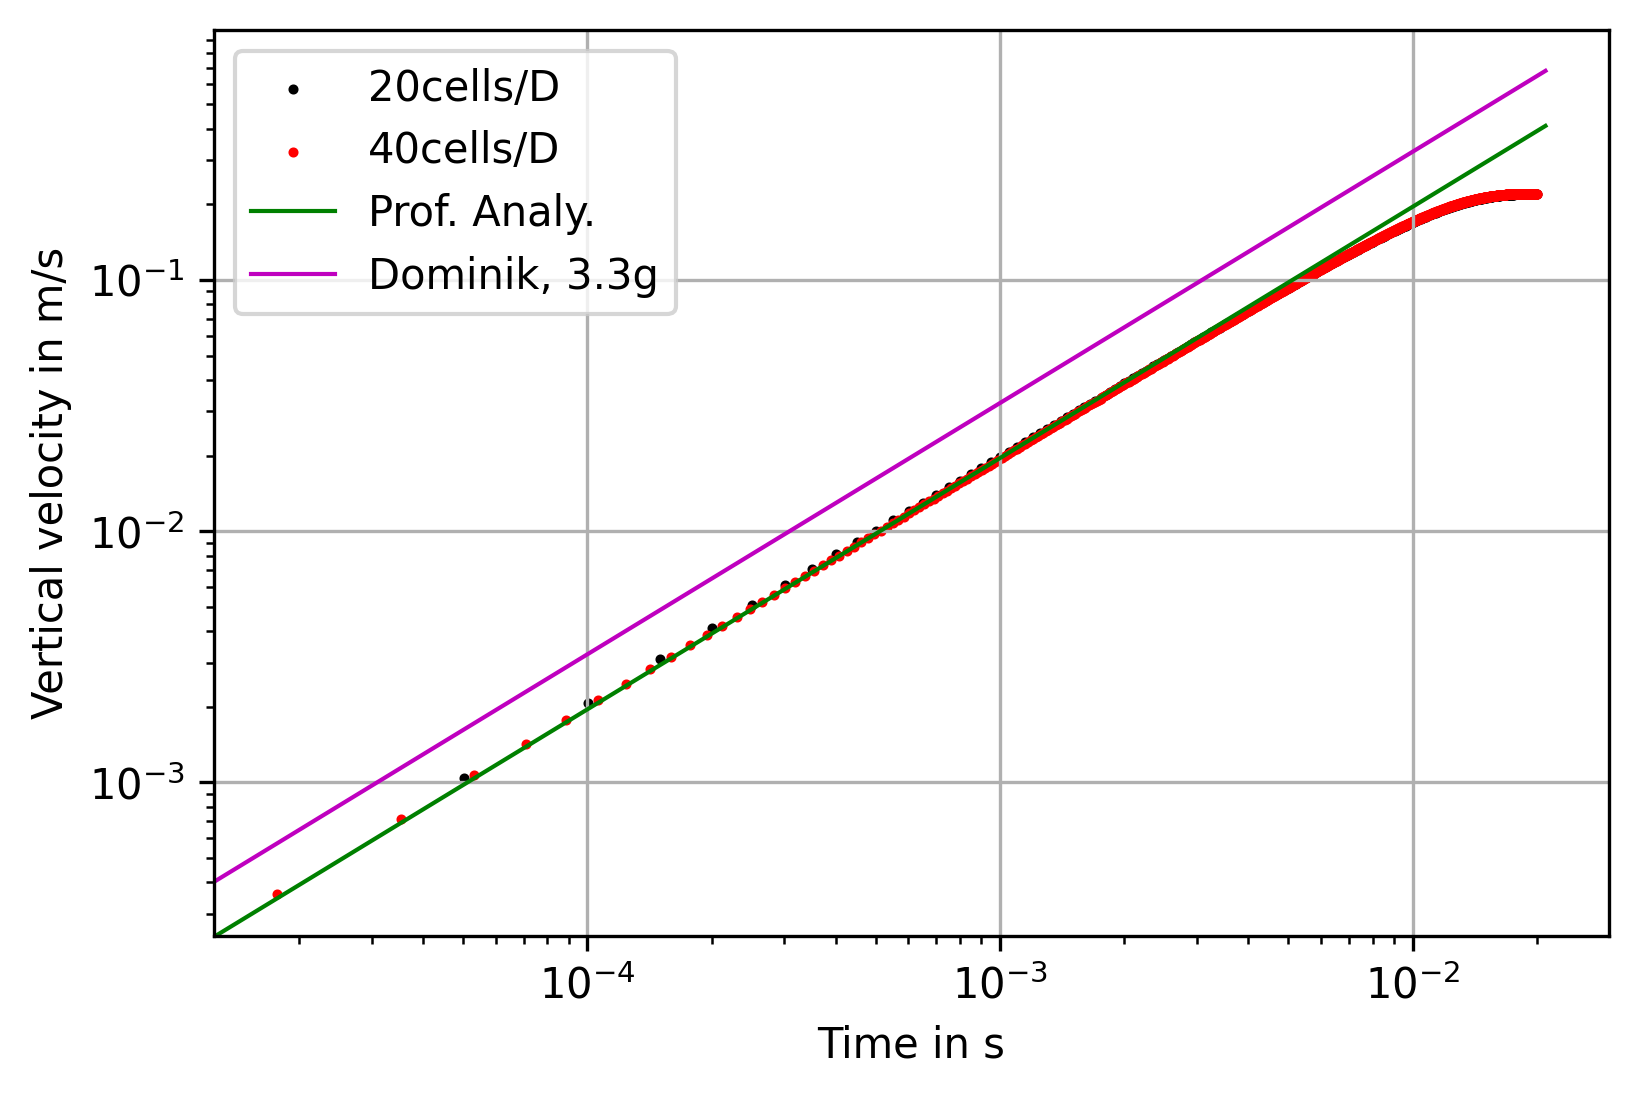

In [72]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(df20["time"], df20["z-Velocity"],s=2, label=r"h$=\frac{D}{20}$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(df40["time"], df40["z-Velocity"], s=2,label="40cells/D", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
axes = plt.gca()
xVal= np.linspace(0, 0.021, num=1000)#df40["time"] #np.array(axes.get_xlim())
yVal1= acc*xVal
yVal2= 3.3*g*xVal

plt.plot(xVal, yVal1,color='g', label="Prof. Analy.", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical velocity in m/s")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig('VelTimeLogScale.png', facecolor='w', dpi=300)
plt.show()

In [59]:
xVal

array([-0.00100041,  0.02100851])

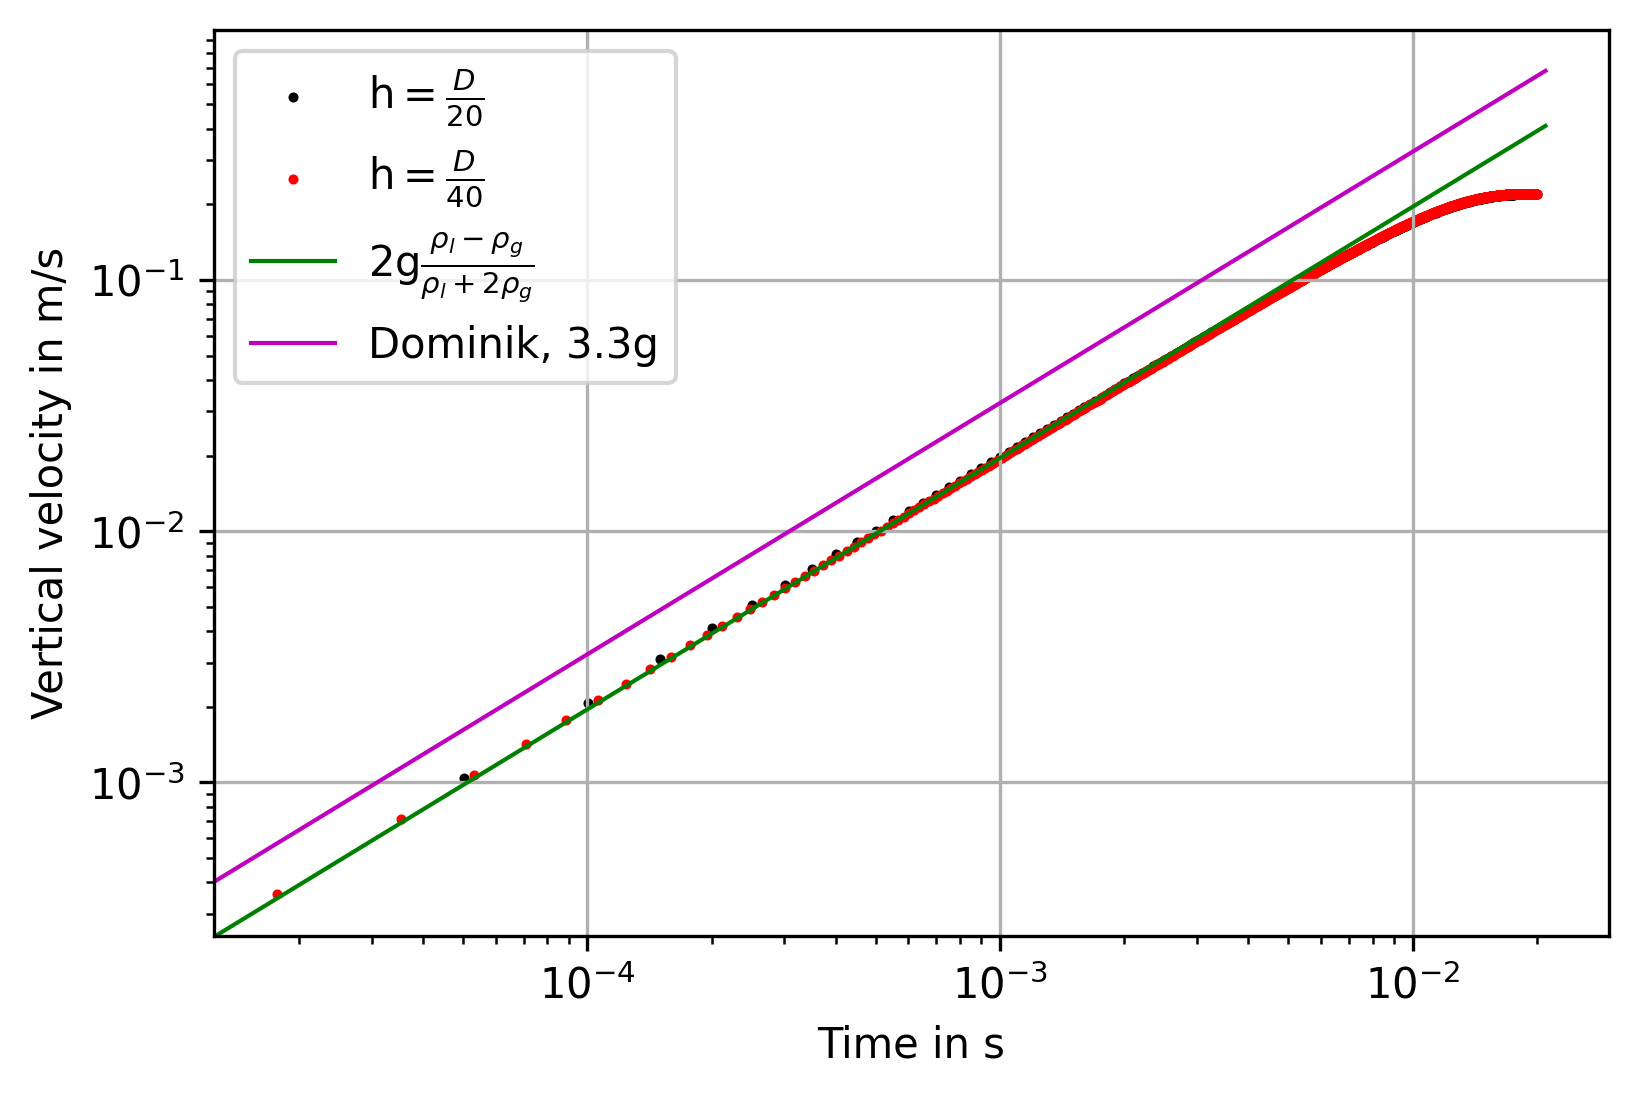

In [20]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(df20["time"], df20["z-Velocity"],s=2, label=r"h$=\frac{D}{20}$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(df40["time"], df40["z-Velocity"], s=2,label=r"h$=\frac{D}{40}$", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
axes = plt.gca()
xVal= np.linspace(0, 0.021, num=1000)#df40["time"] #np.array(axes.get_xlim())
yVal1= acc*xVal
yVal2= 3.3*g*xVal

plt.plot(xVal, yVal1,color='g', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical velocity in m/s")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig('VelTimeLogScale.png', facecolor='w', dpi=300)
plt.show()

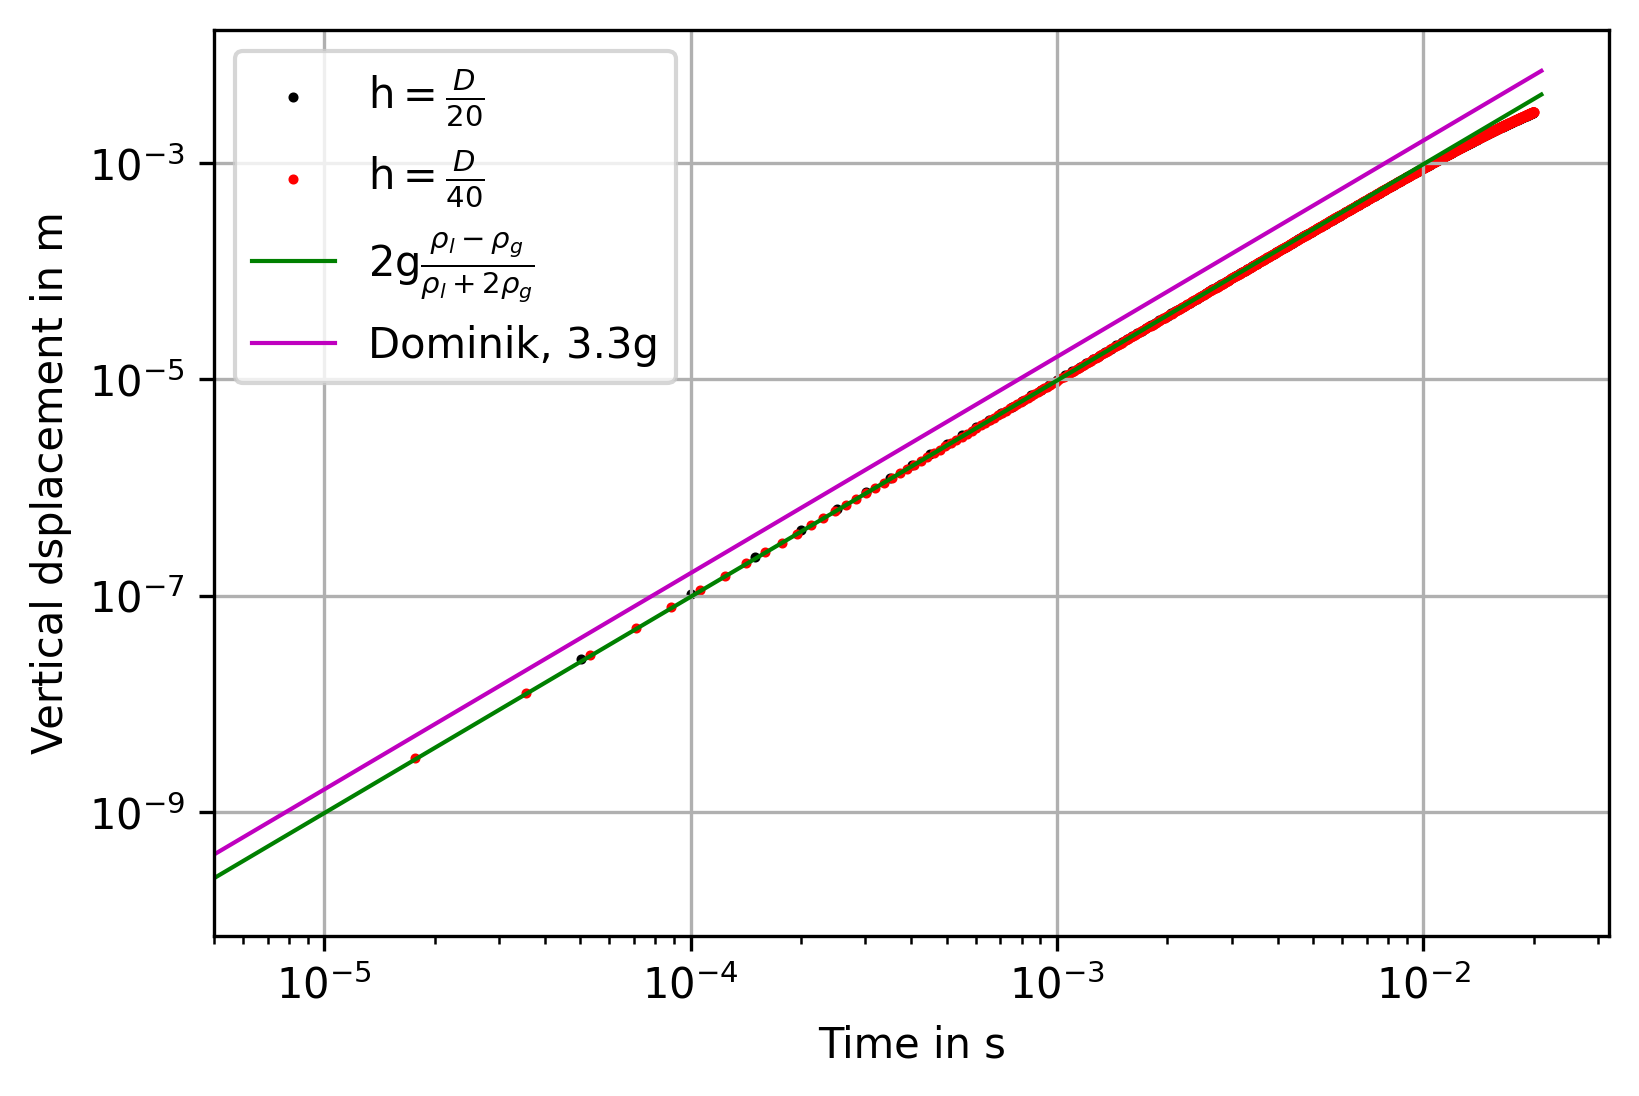

In [28]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(df20["time"], df20["bubbleCenterz"],s=2, label=r"h$=\frac{D}{20}$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(df40["time"], df40["bubbleCenterz"], s=2,label=r"h$=\frac{D}{40}$", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
#axes = plt.gca()
xVal = np.linspace(0, 0.021, num=5000) #np.random.uniform(low=0.0, high=0.021, size=(50,)) #np.array(axes.get_xlim())
yVal1= 0.5*acc*xVal*xVal
yVal2= 0.5*3.3*g*xVal*xVal

plt.plot(xVal, yVal1, color='green', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical dsplacement in m")
plt.xscale("log")
plt.yscale("log")
plt.xlim(5e-6)
plt.grid()
plt.legend()
plt.savefig('DispTimeLogScale.png', facecolor='w',dpi=300)
plt.show()

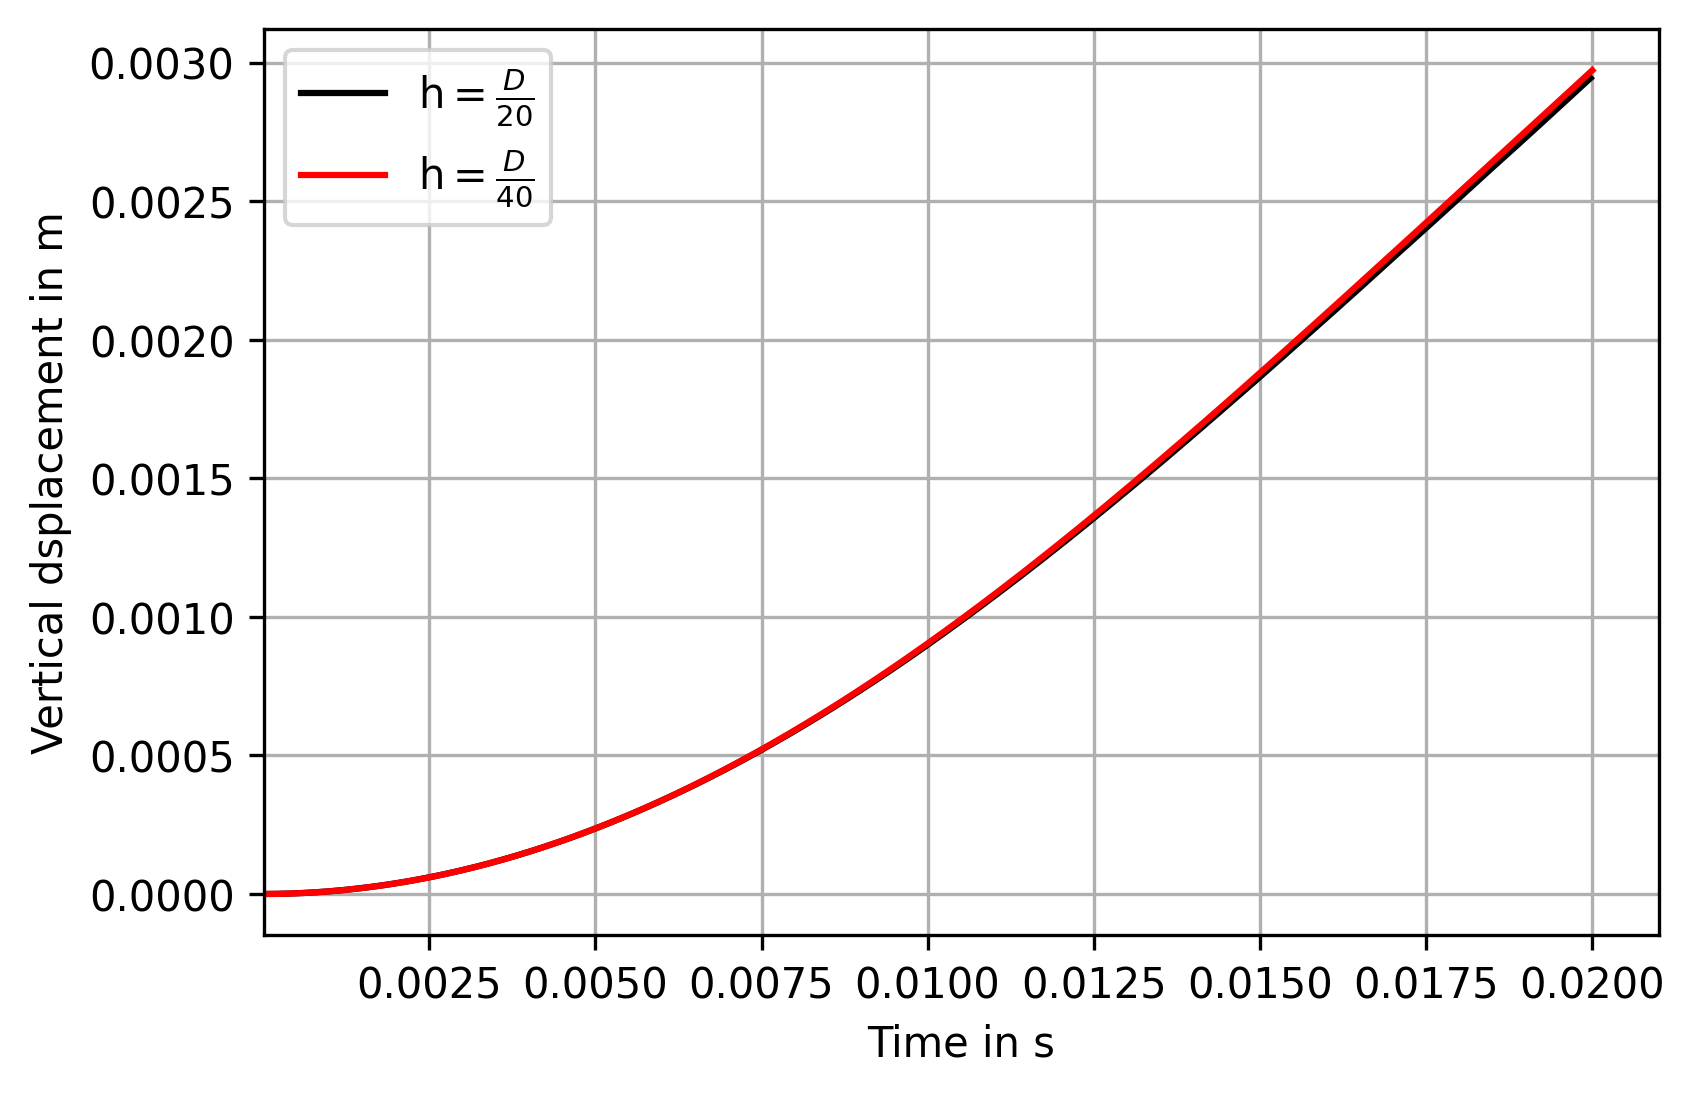

In [42]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.plot(df20["time"], df20["bubbleCenterz"], label=r"h$=\frac{D}{20}$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.plot(df40["time"], df40["bubbleCenterz"],label=r"h$=\frac{D}{40}$", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
#axes = plt.gca()
xVal = np.linspace(0, 0.021, num=5000) #np.random.uniform(low=0.0, high=0.021, size=(50,)) #np.array(axes.get_xlim())
yVal1= 0.5*acc*xVal*xVal
yVal2= 0.5*3.3*g*xVal*xVal

#plt.plot(xVal, yVal1, color='green', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$", linewidth=1)
#plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical dsplacement in m")
#plt.xscale("log")
#plt.yscale("log")
plt.xlim(5e-6)
plt.grid()
plt.legend()
#plt.savefig('DispTimeLogScale.png', facecolor='w',dpi=300)
plt.show()

In [55]:
xVal**2

array([1.00081016e-06, 4.41357282e-04])

In [56]:
xVal

array([-0.00100041,  0.02100851])

In [60]:
xVal = np.random.uniform(low=0.0, high=0.021, size=50)

In [61]:
xVal

array([0.00623508, 0.00709649, 0.00086591, 0.01247745, 0.01578865,
       0.01852986, 0.00551276, 0.00858739, 0.00719606, 0.01857203,
       0.02088652, 0.00152737, 0.01325764, 0.02035066, 0.01311833,
       0.00965863, 0.02024088, 0.00502182, 0.01584723, 0.00896678,
       0.01733302, 0.01736371, 0.01634209, 0.00436992, 0.01369149,
       0.01567962, 0.00247744, 0.01146631, 0.01193597, 0.00237793,
       0.00013707, 0.01858927, 0.00931514, 0.01465121, 0.013464  ,
       0.02092311, 0.00503126, 0.01244191, 0.01647002, 0.00729031,
       0.00873954, 0.01753792, 0.01623358, 0.01793259, 0.01821547,
       0.01553681, 0.01157849, 0.00748065, 0.0022044 , 0.01701364])

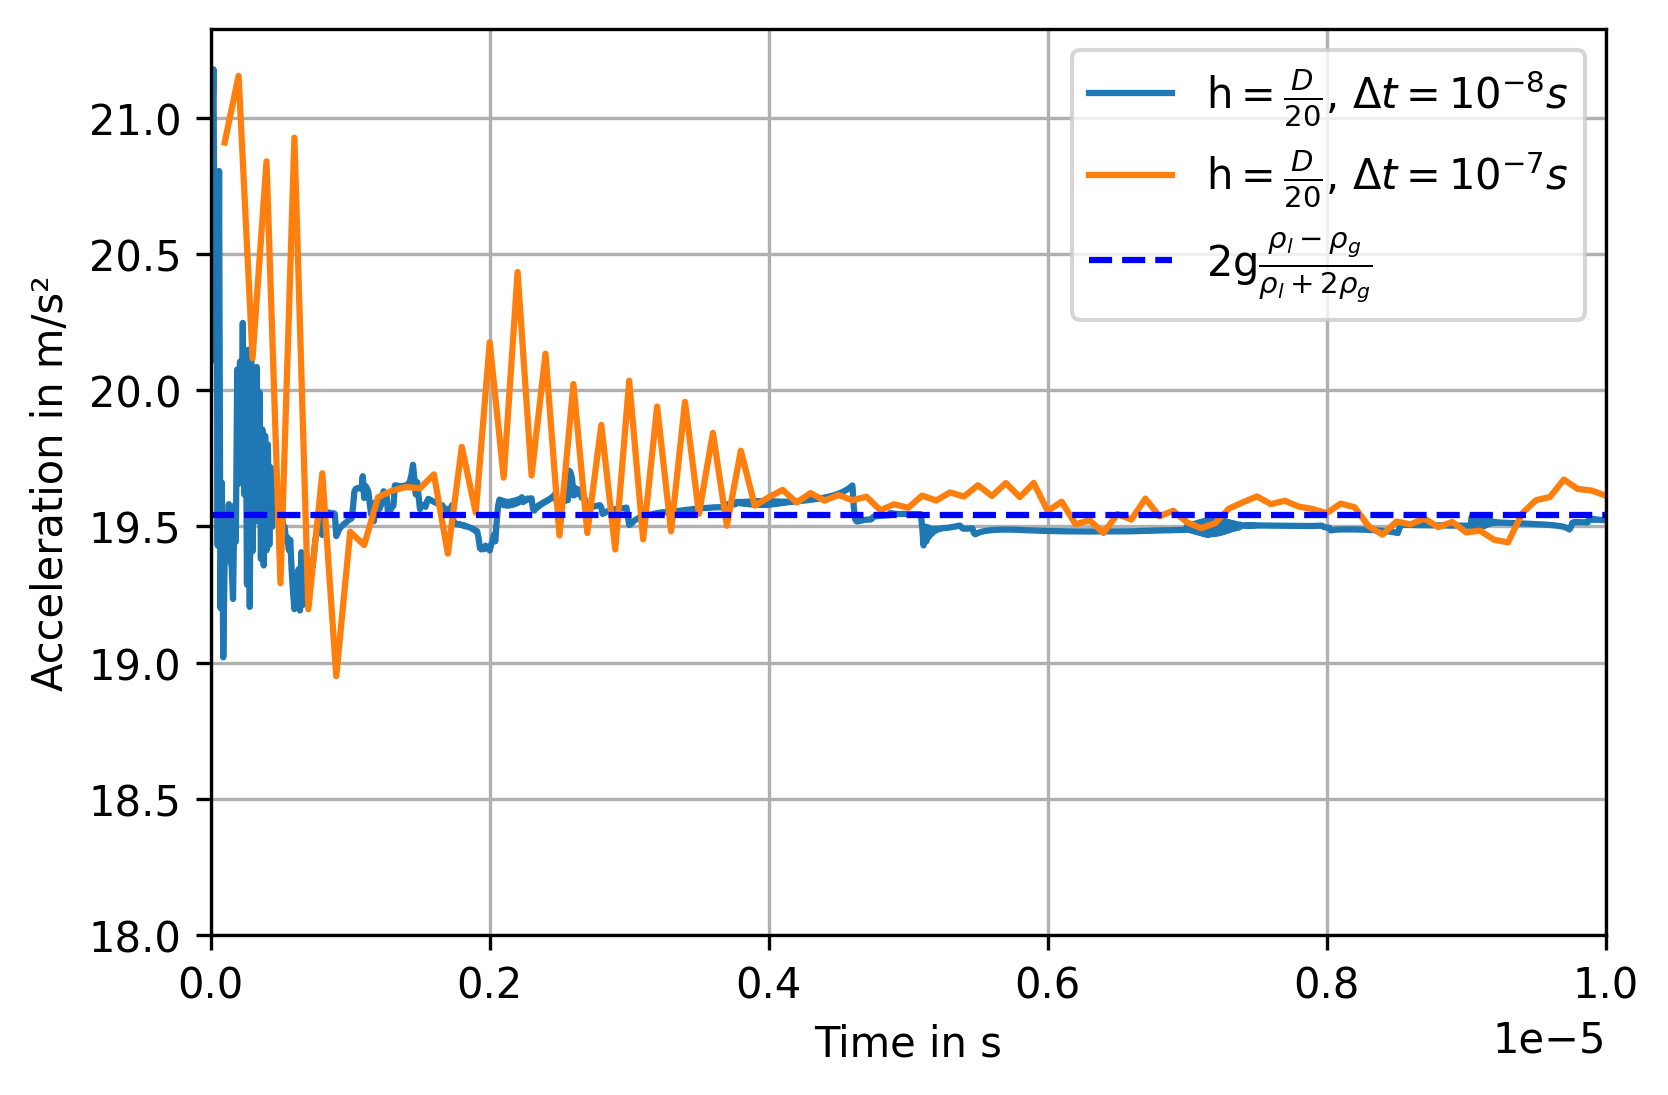

In [41]:
timeStepMinus9 = pd.read_csv('timeStep-MatthiasSetup_00000_templateCase/bubblepproc.dat', sep="\t", header=0)
timeStepMinus8 = pd.read_csv('timeStep-MatthiasSetup_00001_templateCase/bubblepproc.dat', sep="\t", header=0)
timeStepMinus7 = pd.read_csv('timeStep-MatthiasSetup_00002_templateCase/bubblepproc.dat', sep="\t", header=0)
timeStepMinus6 = pd.read_csv('timeStep-MatthiasSetup_00003_templateCase/bubblepproc.dat', sep="\t", header=0)
timeStepMinus5 = pd.read_csv('newSize-risingBubbleAcc3D_00000_templateCase/bubblepproc.dat', sep="\t", header=0)

timeStepMinus81 = pd.read_csv('testResidualControl_01/bubblepproc.dat', sep="\t", header=0)
timeStepMinus82 = pd.read_csv('testVarieddT_01/bubblepproc.dat.5steps10dtsEach', sep="\t", header=0)
timeStepMinus83 = pd.read_csv('testMULES/bubblepproc.dat', sep="\t", header=0)
timeStepMinus84 = pd.read_csv('testMULESVariedDt_01/bubblepproc.dat', sep="\t", header=0)

accMinus9 = linalg.norm(timeStepMinus9[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus9["time"].diff()
#velMinus9 = linalg.norm(timeStepMinus9[["bubbleCenterx","bubbleCentery","bubbleCenterz"]].diff(), axis=1)/timeStepMinus9["time"].diff()
#velMinus9 = timeStepMinus9["bubbleCenterz"].diff()/timeStepMinus9["time"].diff()
#velMinus9.iloc[0]=0
#accMinus91 = velMinus9.diff()/timeStepMinus9["time"].diff()

#accMinus8 = linalg.norm(timeStepMinus8[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus8["time"].diff()
#accMinus7 = linalg.norm(timeStepMinus7[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus7["time"].diff()
accMinus8 = timeStepMinus8["z-Velocity"].diff()/timeStepMinus8["time"].diff()
accMinus7 = timeStepMinus7["z-Velocity"].diff()/timeStepMinus7["time"].diff()

accMinus6 = linalg.norm(timeStepMinus6[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus6["time"].diff()
accMinus5 = linalg.norm(timeStepMinus5[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus5["time"].diff()
accMinus81 = linalg.norm(timeStepMinus81[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus81["time"].diff()
accMinus82 = linalg.norm(timeStepMinus82[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus82["time"].diff()
accMinus83 = linalg.norm(timeStepMinus83[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus83["time"].diff()
accMinus84 = linalg.norm(timeStepMinus84[["x-Velocity","y-Velocity","z-Velocity"]].diff(), axis=1)/timeStepMinus84["time"].diff()


rcParams["figure.dpi"] = 300
g = 9.80665
rhol= 997
rhog = 1.225

acc = 2*g*(rhol - rhog)/(rhol+2*rhog)

#plt.plot(timeStepMinus9["time"].iloc[2:], np.diff(timeStepMinus9["bubbleCenterz"], n=2)/1e-9**2,label="test")
#plt.plot(timeStepMinus9["time"].iloc[2:], accMinus91.iloc[2:], label="timeStepMinus91")
#plt.plot(timeStepMinus9["time"], np.gradient(timeStepMinus9['z-Velocity'], timeStepMinus9['time']), edge_order=2,label="timeStepMinus9_gradient")

#plt.plot(timeStepMinus9["time"], accMinus9, label="timeStepMinus9")

#plt.plot(timeStepMinus8["time"].iloc[::10], accMinus8.iloc[::10], label="timeStepMinus8")

plt.plot(timeStepMinus8["time"], accMinus8, label=r"h$=\frac{D}{20}$, $\Delta t=10^{-8}s$")
#plt.plot(timeStepMinus81["time"], accMinus81, label="timeStepMinus81", alpha=0.6)
#plt.plot(timeStepMinus82["time"], accMinus82, label="timeStepMinus8_smallIniDt", alpha=0.8)
#plt.plot(timeStepMinus83["time"], accMinus83, label="timeStepMinus8_MULES",color='r', alpha=0.6)
#plt.plot(timeStepMinus84["time"], accMinus84, label="timeStepMinus8_MULES_smallIniDt",color='r', alpha=0.6)
plt.plot(timeStepMinus7["time"], accMinus7, label=r"h$=\frac{D}{20}$, $\Delta t=10^{-7}s$")
#plt.plot(timeStepMinus6["time"], accMinus6, label="timeStepMinus6")
#plt.plot(timeStepMinus5["time"], accMinus5, label="timeStepMinus5")
plt.axhline(y=acc, linestyle='--', color='blue', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$")
plt.xlim(0,1e-5) #7.1e-5)
plt.ylim(18)
#plt.xticks([0,0.005,0.01,0.015,0.02])
#plt.plot(t, vel, label="Analytical")
plt.xlabel("Time in s")
plt.ylabel("Acceleration in m/s²")
plt.grid()
plt.legend()
plt.savefig('accPlot_timeStepMinus8_comp.png', facecolor='w')
plt.show()

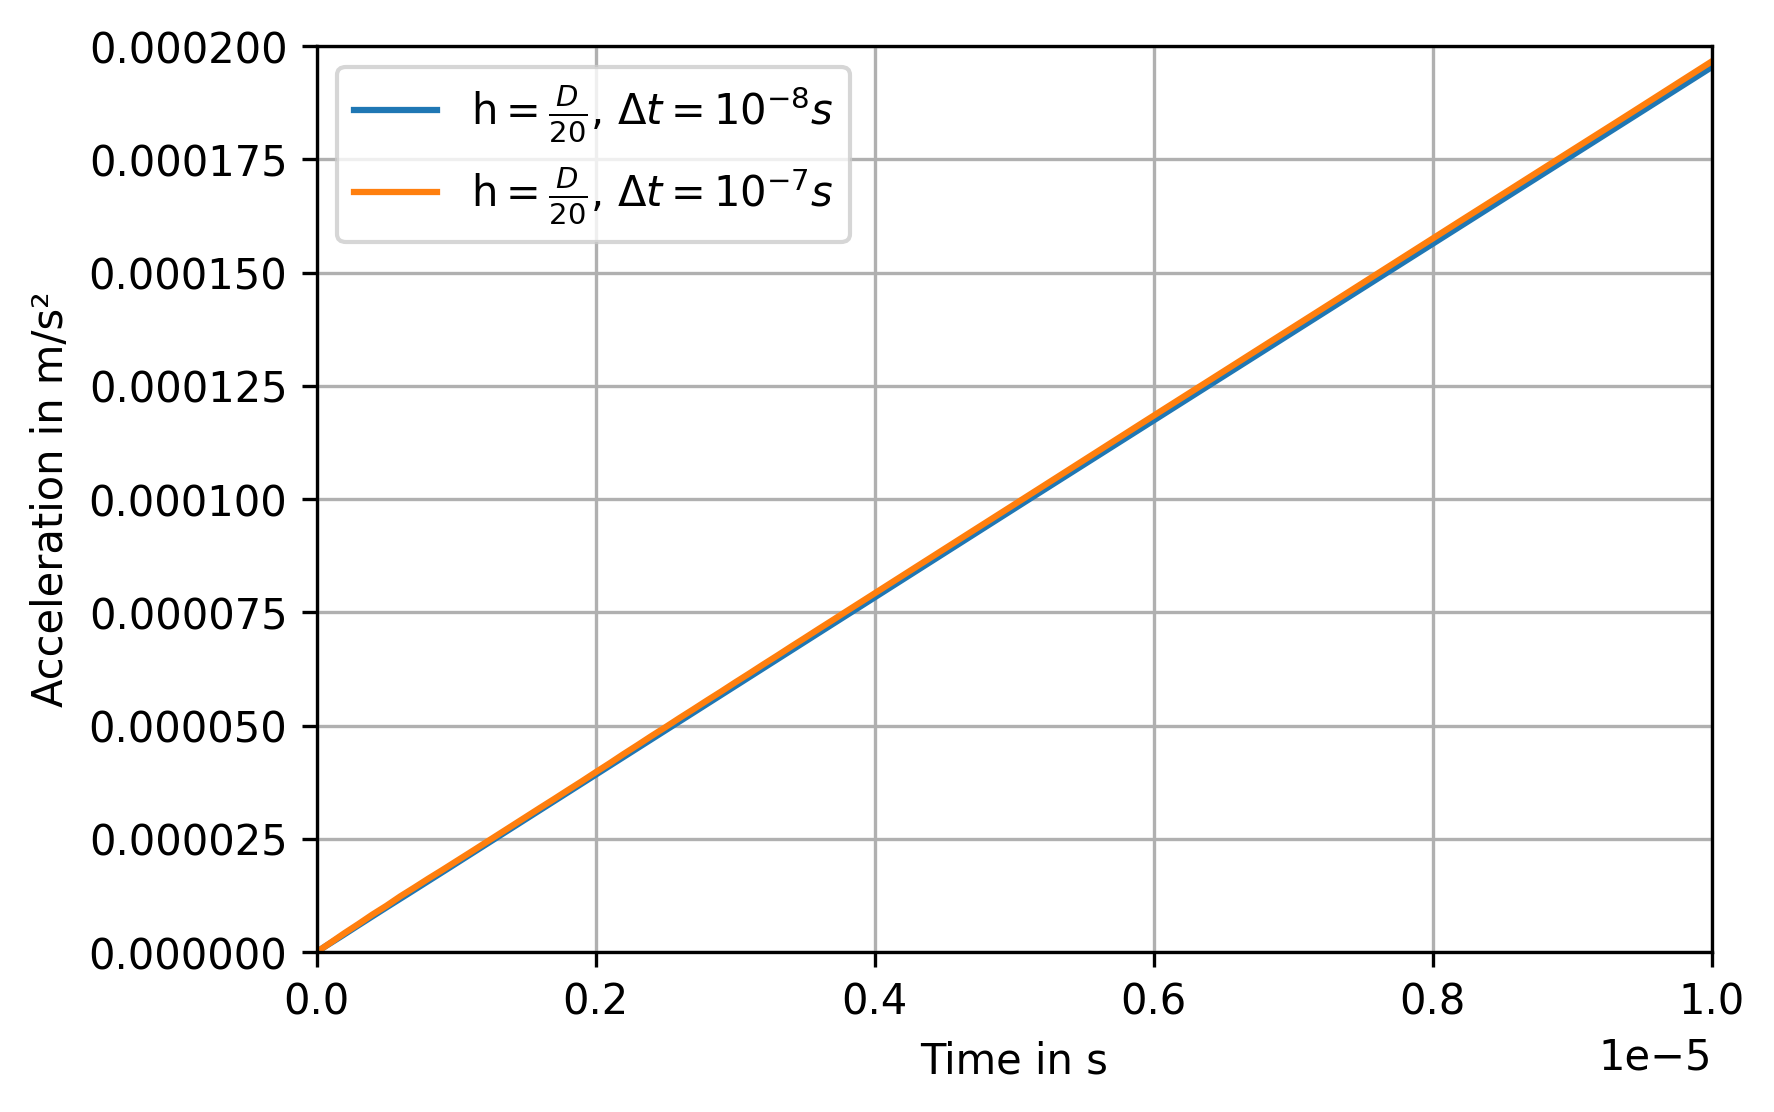

In [48]:
plt.plot(timeStepMinus8["time"], timeStepMinus8["z-Velocity"], label=r"h$=\frac{D}{20}$, $\Delta t=10^{-8}s$")
#plt.plot(timeStepMinus81["time"], accMinus81, label="timeStepMinus81", alpha=0.6)
#plt.plot(timeStepMinus82["time"], accMinus82, label="timeStepMinus8_smallIniDt", alpha=0.8)
#plt.plot(timeStepMinus83["time"], accMinus83, label="timeStepMinus8_MULES",color='r', alpha=0.6)
#plt.plot(timeStepMinus84["time"], accMinus84, label="timeStepMinus8_MULES_smallIniDt",color='r', alpha=0.6)
plt.plot(timeStepMinus7["time"], timeStepMinus7["z-Velocity"], label=r"h$=\frac{D}{20}$, $\Delta t=10^{-7}s$")
#plt.plot(timeStepMinus6["time"], accMinus6, label="timeStepMinus6")
#plt.plot(timeStepMinus5["time"], accMinus5, label="timeStepMinus5")
#plt.axhline(y=acc, linestyle='--', color='blue', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$")
plt.xlim(0,1e-5) #7.1e-5)
plt.ylim(0,2e-4)
#plt.xticks([0,0.005,0.01,0.015,0.02])
#plt.plot(t, vel, label="Analytical")
plt.xlabel("Time in s")
plt.ylabel("Velocity in m/s")
plt.grid()
plt.legend()
plt.savefig('velPlot_timeStepMinus8_comp.png', facecolor='w')
plt.show()

In [40]:
accMinus82.iloc[0:20]

0           NaN
1     19.744836
2     20.886335
3     21.949983
4     19.905846
5     19.935492
6     20.195759
7     19.268296
8     19.892809
9     19.090221
10    19.548422
11    19.296137
12    19.591395
13    19.451035
14    19.494365
15    19.247408
16    19.463236
17    19.329430
18    19.904849
19    19.713641
Name: time, dtype: float64

In [47]:
accMinus82.iloc[0:20]

0           NaN
1     19.744836
2     19.788266
3     19.866170
4     19.954373
5     20.219517
6     20.170917
7     20.265160
8     20.309147
9     19.758782
10    19.822959
11    19.581911
12    19.558288
13    19.456835
14    19.529867
15    19.475097
16    19.666263
17    19.531133
18    19.819800
19    19.773056
Name: time, dtype: float64

In [55]:
accMinus82.iloc[0:20]

0           NaN
1     19.744836
2     19.788266
3     19.490100
4     19.993453
5     19.531137
6     19.452044
7     20.248325
8     19.745914
9     19.598042
10    19.499195
11    20.413607
12    20.071406
13    19.910301
14    19.803290
15    19.774730
16    20.426170
17    19.766661
18    19.762370
19    19.876980
Name: time, dtype: float64

In [41]:
accMinus8.iloc[0:20]

0           NaN
1     20.909639
2     21.177978
3     20.109046
4     20.749155
5     19.429769
6     20.804826
7     19.200593
8     19.660864
9     19.019792
10    19.381968
11    19.475339
12    19.396033
13    19.581890
14    19.370778
15    19.358271
16    19.234049
17    19.577001
18    19.444001
19    20.076408
Name: time, dtype: float64

In [4]:
velMinus9.iloc[0]=0
velMinus9

0        0.000000
1       20.909672
2       21.241278
3       20.181168
4       20.710646
          ...    
7450    19.484866
7451    19.484857
7452    19.484847
7453    19.484836
7454    19.484825
Name: time, Length: 7455, dtype: float64

In [96]:
np.gradient(timeStepMinus9['z-Velocity'], timeStepMinus9['time'])

array([20.90967218, 21.07547529, 20.71122336, ..., 19.48484165,
       19.48483095, 19.4848255 ])

In [95]:
accMinus9.iloc[:20]

0           NaN
1     20.909672
2     21.241278
3     20.181168
4     20.710646
5     19.429569
6     20.912275
7     19.176746
8     19.706349
9     19.070857
10    19.520527
11    19.384094
12    19.486962
13    19.464101
14    19.395461
15    19.213812
16    19.395420
17    19.336582
18    19.733648
19    19.735364
Name: time, dtype: float64

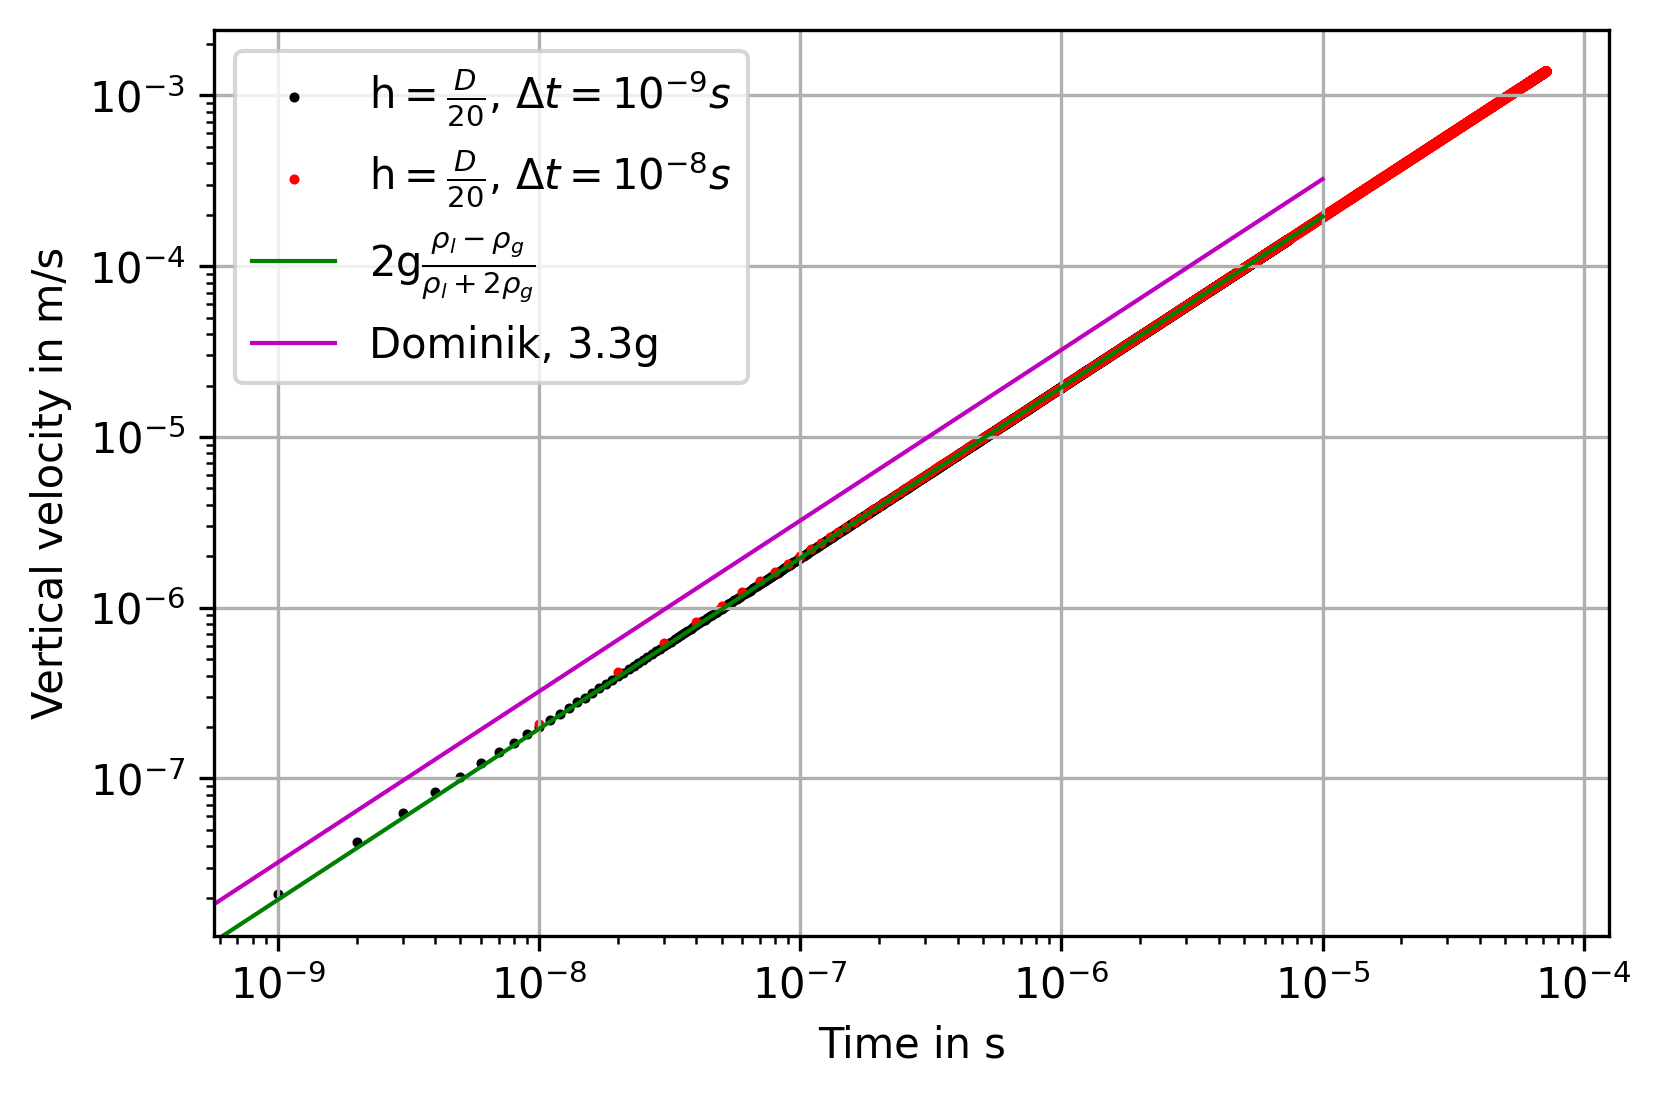

In [18]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(timeStepMinus9["time"], timeStepMinus9["z-Velocity"],s=2, label=r"h$=\frac{D}{20}$, $\Delta t=10^{-9}s$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(timeStepMinus8["time"], timeStepMinus8["z-Velocity"], s=2,label=r"h$=\frac{D}{20}$, $\Delta t=10^{-8}s$", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
axes = plt.gca()
xVal= np.linspace(0, 1e-5, num=1000)#df40["time"] #np.array(axes.get_xlim())
yVal1= acc*xVal
yVal2= 3.3*g*xVal

plt.plot(xVal, yVal1,color='g', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical velocity in m/s")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig('smallDelT_VtLogScale.png', facecolor='w', dpi=300)
plt.show()

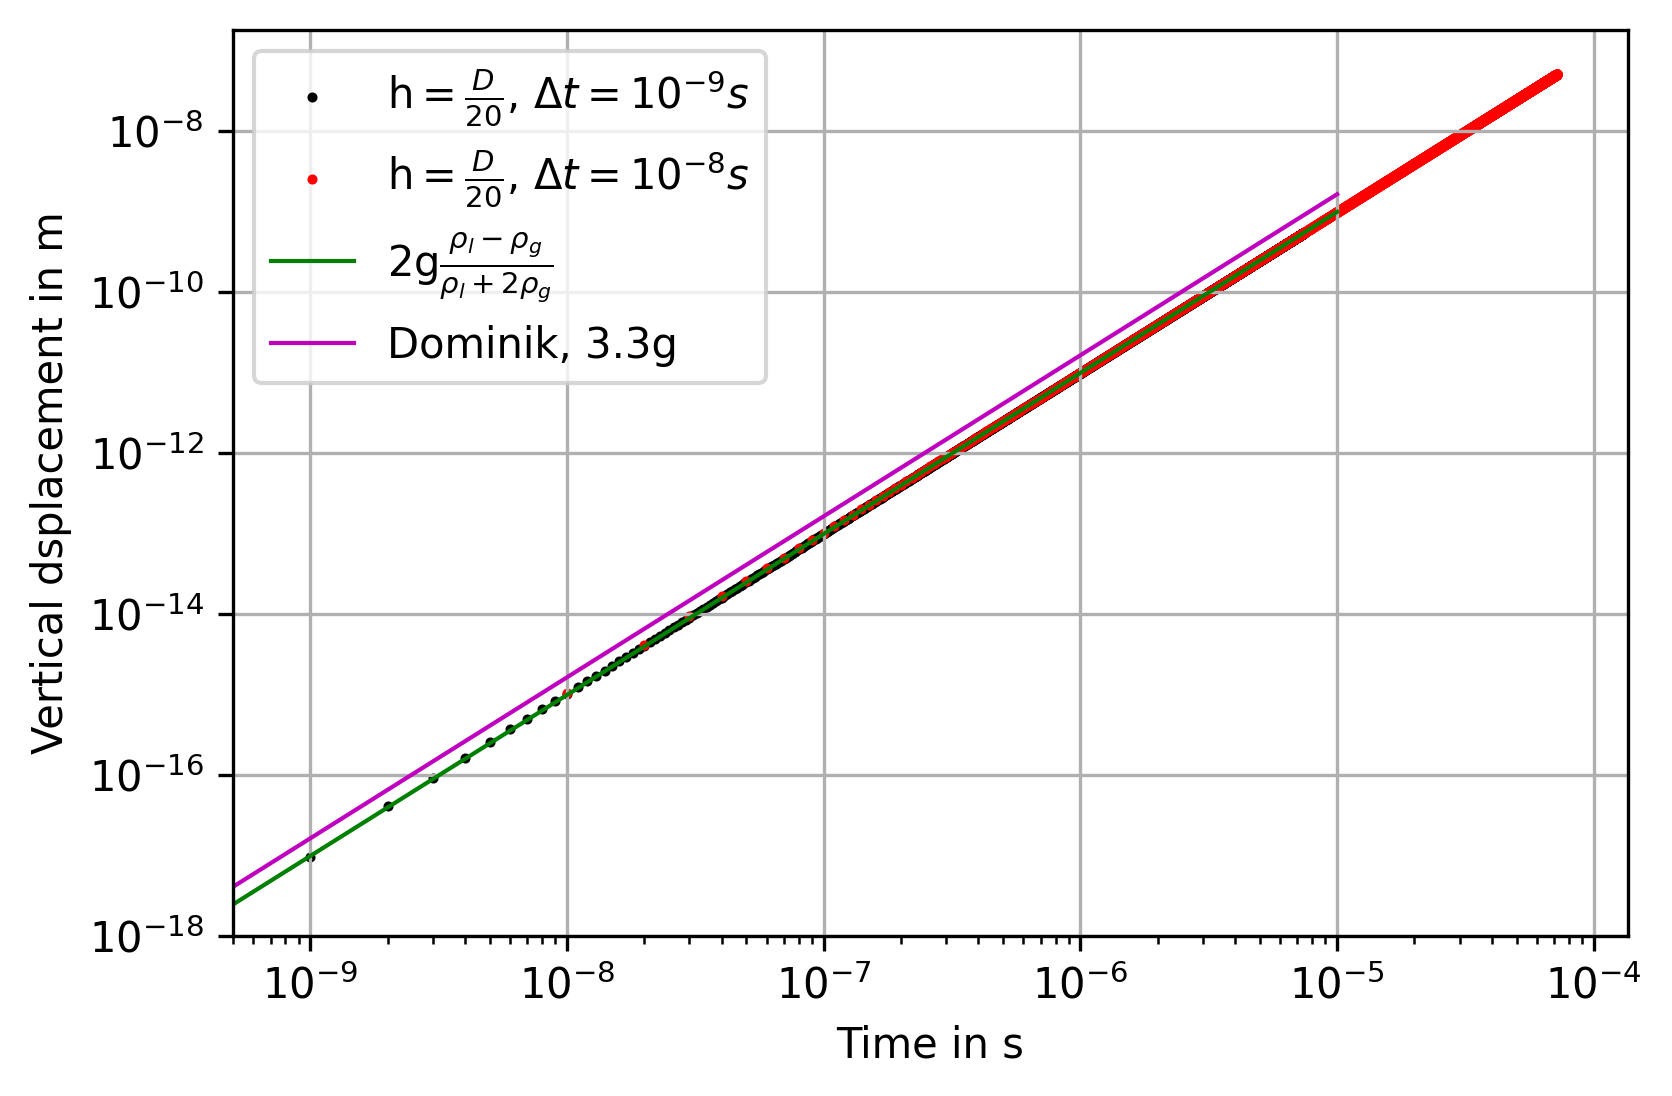

In [29]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(timeStepMinus9["time"], timeStepMinus9["bubbleCenterz"],s=2, label=r"h$=\frac{D}{20}$, $\Delta t=10^{-9}s$", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(timeStepMinus8["time"], timeStepMinus8["bubbleCenterz"], s=2,label=r"h$=\frac{D}{20}$, $\Delta t=10^{-8}s$", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
axes = plt.gca()
xVal= np.linspace(0, 1e-5, num=50000)#df40["time"] #np.array(axes.get_xlim())
yVal1= 0.5*acc*xVal*xVal
yVal2= 0.5*3.3*g*xVal*xVal

plt.plot(xVal, yVal1,color='g', label=r"$2$g$\frac{\rho_l-\rho_g}{\rho_l+2\rho_g}$", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical dsplacement in m")
plt.xscale("log")
plt.yscale("log")
plt.xlim(5e-10)
plt.ylim(1e-18)
plt.grid()
plt.legend()
plt.savefig('smallDelT_DisptLogScale.png', facecolor='w', dpi=300)
plt.show()

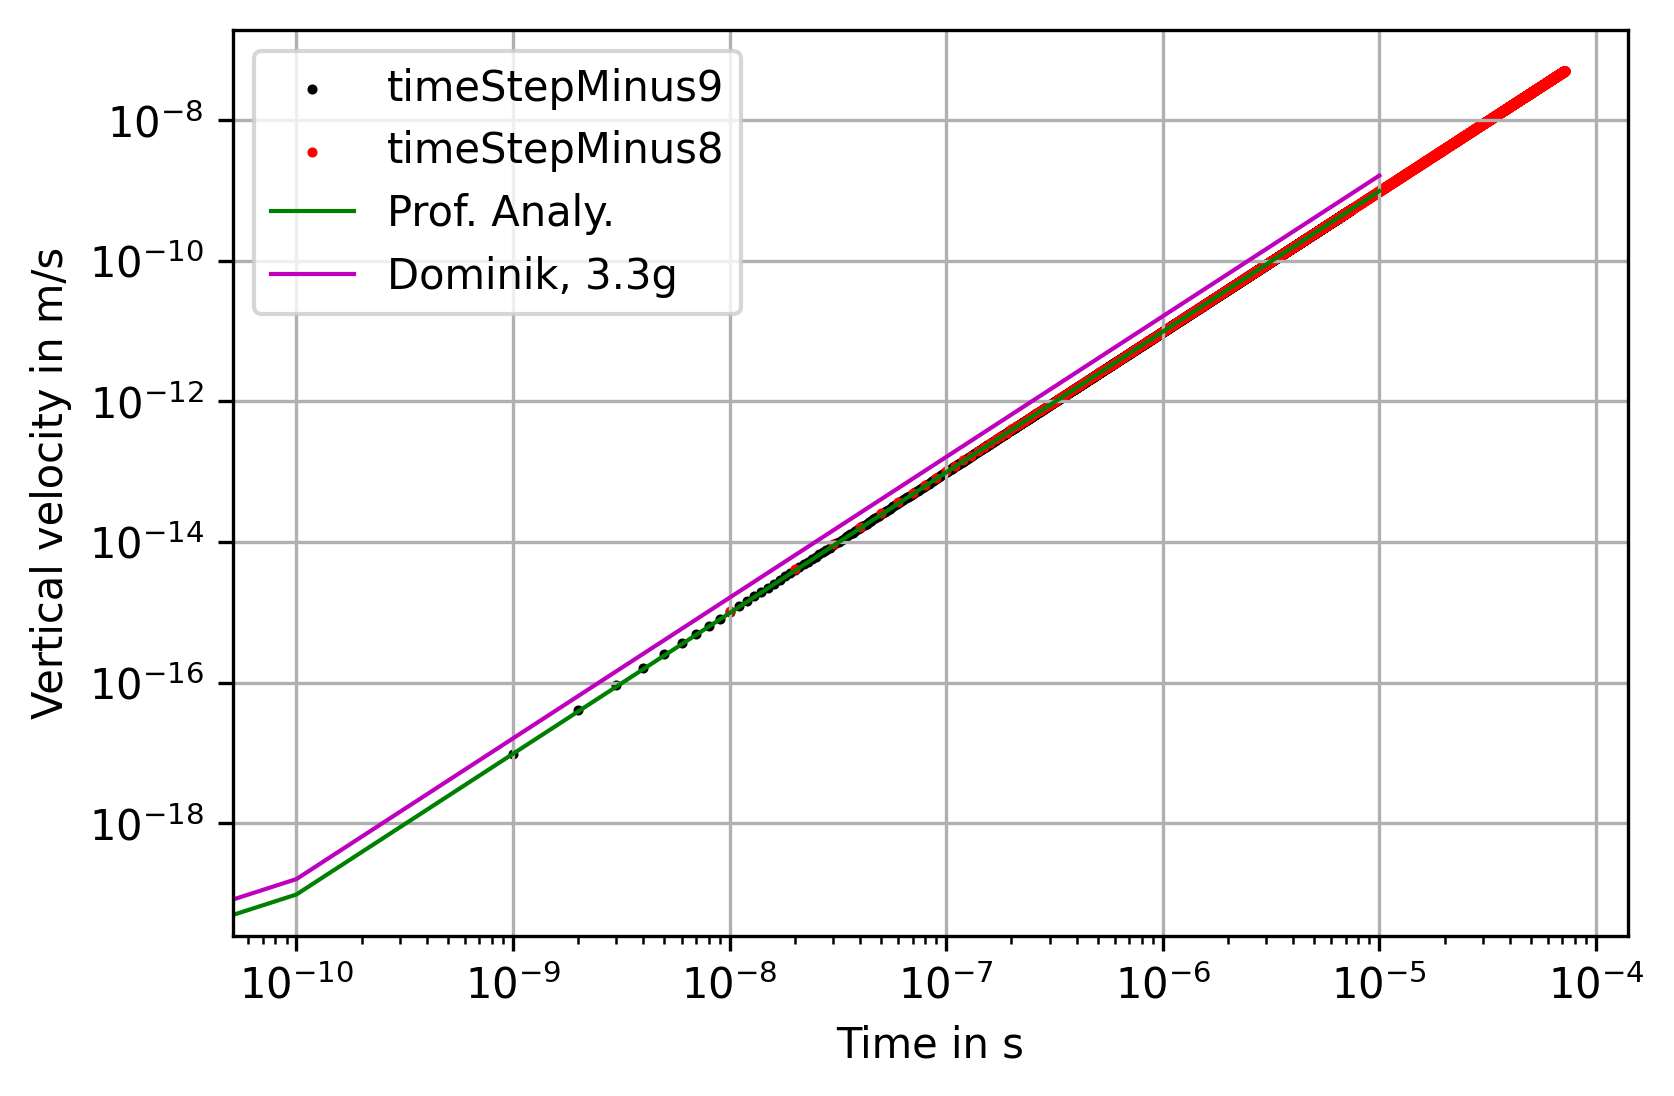

In [89]:
#plt.plot(df20["time"], df20["z-Velocity"], label="20cells/D", marker="o", markevery=10)
plt.scatter(timeStepMinus9["time"], timeStepMinus9["bubbleCenterz"],s=2, label="timeStepMinus9", color='black')
#plt.plot(df40["time"], df40["z-Velocity"], label="40cells/D", marker="o", markevery=20)
plt.scatter(timeStepMinus8["time"], timeStepMinus8["bubbleCenterz"], s=2,label="timeStepMinus8", color='red')
#plt.axhline(y=math.log(acc), linestyle='--', color='blue', label="AnalyIni(19.54246)")
#plt.xlim(0,0.001)
#plt.ylim(18)
axes = plt.gca()
xVal= np.linspace(0, 1e-5, num=100000)#df40["time"] #np.array(axes.get_xlim())
yVal1= 0.5*acc*xVal*xVal
yVal2= 0.5*3.3*g*xVal*xVal

plt.plot(xVal, yVal1,color='g', label="Prof. Analy.", linewidth=1)
plt.plot(xVal, yVal2, color='m', label="Dominik, 3.3g", linewidth=1)
plt.xlabel("Time in s")
plt.ylabel("Vertical velocity in m/s")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig('smallDelT_AcctLogScale.png', facecolor='w', dpi=300)
plt.show()